In [22]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from seaborn import heatmap

# Task 1

## Part 1

### 1.

#### a.

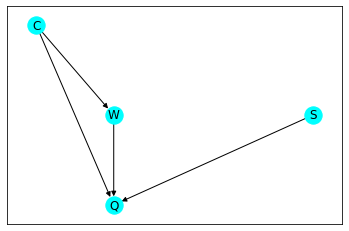

In [2]:
G = nx.DiGraph()

G.add_edges_from([
    ('C', 'Q'),
    ('W', 'Q'),
    ('S', 'Q'),
    ('C', 'W')
])

pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, node_color='cyan', pos=pos)

#### b.

$$P(Q, W, S, C) \propto P(Q | W, S, C) \cdot P(W | C) \cdot P(S) \cdot P(C)$$

### 2.

<AxesSubplot:>

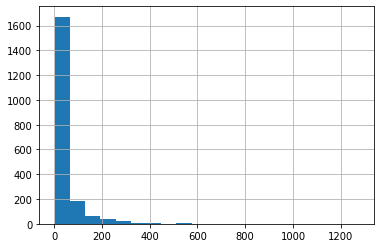

In [3]:
import pandas as pd

df_qc_train = pd.read_csv('QualityControlTraining.csv')
df_qc_train.Wait_Time.hist(bins=20)

The histogram for wait time is heavily skewed right

<AxesSubplot:>

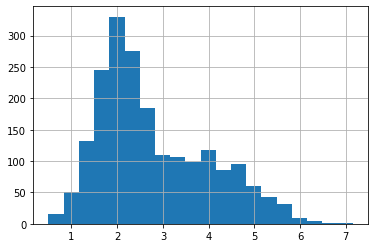

In [4]:
np.log(df_qc_train.Wait_Time).hist(bins=20)

This histogram appears to be a mixture of two gaussians, where the first is centered around 2 with small variance and the second is centered around 3.5 with larger variance.

### 3.

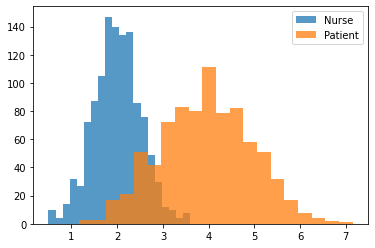

In [5]:
lg_wait_time_nurse = np.log(df_qc_train[df_qc_train.Collection_Method == 'Nurse'].Wait_Time)
lg_wait_time_patient = np.log(df_qc_train[df_qc_train.Collection_Method == 'Patient'].Wait_Time)

bins = 20
alpha = .75

plt.hist(lg_wait_time_nurse, bins=bins, alpha=alpha)
plt.hist(lg_wait_time_patient, bins=bins, alpha=alpha)
plt.legend(['Nurse', 'Patient'])

In [6]:
mean, std = lg_wait_time_nurse.mean(), lg_wait_time_nurse.std()
print(f'Nurse stats: mean = {mean:.3f}, std = {std:.3f}')

Nurse stats: mean = 1.997, std = 0.519


### 4.

#### a.

For each $C \in \{P, N\}$,
$$Q | C, W, S \sim \mathcal{N}(\mu_C(W,S), \sigma_C),$$
where
\begin{align*}
    \mu_C(w, s) &= \begin{bmatrix}1 & \log(w) & s\end{bmatrix}^\top a_C & \text{for some fixed } a_C &\in \mathbb{R}^3, \\
    \sigma_C &\in \mathbb{R} \text{ is fixed}
\end{align*}

#### b.

$$P_{\theta_P}(q_i, w_i, s_i, \text{P}) = P_{\theta_P}(q_i | w_i, s_i, \text{P}) \cdot P(w_i | \text{P}) \cdot P(s_i) \cdot P(\text{P})$$

#### c.

\begin{align*}
P_{\theta_P}(q_i, w_i, s_i, \text{P}) &\propto_{\theta_P} P_{\theta_P}(q_i | w_i, s_i, \text{P}) \\
&\propto_{\theta_P} \frac{1}{\sigma_P} \exp\left( -\frac{1}{2\sigma_P^2} \left(q_i - \begin{bmatrix}1 & \log(w_i) & s_i\end{bmatrix}^\top a_P \right)^2 \right) \\
\Rightarrow \theta^*_P &= \underset{\sigma_P, a_P}{\arg\max} \; \sigma_P^{-|I_P|} \exp\left( -\frac{1}{2\sigma_P^2} \sum_{i\in I_P}   \left(q_i - \begin{bmatrix}1 & \log(w_i) & s_i\end{bmatrix}^\top a_P \right)^2 \right) \\
&= \underset{\sigma_P, a_P}{\arg\min} \; \log \sigma_P + \frac{1}{2\sigma_P^2} \sum_{i\in I_P}   \left(q_i - \begin{bmatrix}1 & \log(w_i) & s_i\end{bmatrix}^\top a_P \right)^2
\end{align*}

In [19]:
df_qc_train_patient = df_qc_train[df_qc_train.Collection_Method == 'Patient']

q = df_qc_train_patient.Quality_Score
z = np.stack(
    [
        np.ones(len(q)), 
        np.log(df_qc_train_patient.Wait_Time), 
        df_qc_train_patient.Storage_Temperature
    ], 
    axis=1)

def f(theta):
    sigma, a = theta[0], theta[1:]
    return np.log(sigma) + ((q - (z@a))**2).sum() / (2*sigma**2)

minimize(f, x0=[10,1,1,1])

      fun: 4.552765997058457
 hess_inv: array([[ 1.44564491e+03, -7.53584311e+01,  6.02647597e+00,
        -5.58442410e+00],
       [-7.53584311e+01,  4.16913123e+02, -1.13325487e+01,
         3.70114186e+01],
       [ 6.02647597e+00, -1.13325487e+01,  3.71300204e+00,
         3.36086604e-01],
       [-5.58442410e+00,  3.70114186e+01,  3.36086604e-01,
         3.85316206e+00]])
      jac: array([-5.96046448e-08, -2.98023224e-07, -3.57627869e-07,  1.66893005e-06])
  message: 'Optimization terminated successfully.'
     nfev: 205
      nit: 39
     njev: 41
   status: 0
  success: True
        x: array([57.55636657, -9.09228035, -1.91580732, -2.06586948])

#### d.

In [8]:
df_qc_train_patient["Lg_Wait_Time"] = np.log(df_qc_train_patient.Wait_Time)
lg_wait_time_mean = df_qc_train_patient.Lg_Wait_Time.mean()
storage_time_mean = df_qc_train_patient.Storage_Temperature.mean()

wait_time_mask = df_qc_train_patient.Lg_Wait_Time.between(lg_wait_time_mean - 0.05, lg_wait_time_mean + 0.05)
storage_time_mask = df_qc_train_patient.Storage_Temperature.between(storage_time_mean - 0.05, storage_time_mean + 0.05)
quality_score_std = df_qc_train_patient[wait_time_mask & storage_time_mask].Quality_Score.std()
quality_score_std ** 2

/var/folders/cm/nnvrqpxx7pd3kpx8lpmjk6c80000gn/T/ipykernel_2128/2213373757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_qc_train_patient["Lg_Wait_Time"] = np.log(df_qc_train_patient.Wait_Time)


4.685429319246753

**(iii) How does the variance compare with the estimated variance in (c)**

### 5.

In [9]:
## Train with df_qc_train and classify based on Collection_Method
## Evaluate and create predictions with same df, but missing Collection_Method values
# Goal: P(C | W, S, Q)

# argmax_C P(C | W, S, Q) = argmax_C P(C, W, S, Q) = argmax_C P(Q | W, S, C) P(W | C) P(C)


df_qc_train

,Collection_Method,Wait_Time,Storage_Temperature,Quality_Score
0,Nurse,4.763624,-10.826880,14.979513
1,Patient,78.835666,-9.086415,-0.168258
2,Patient,242.909408,-10.271124,1.514135
3,Nurse,5.085504,-12.424240,18.664109
4,Nurse,10.680525,-10.281328,13.227729
...,...,...,...,...
1995,Patient,6.552933,-10.736064,9.090427
1996,Patient,100.472097,-10.039926,4.449939
1997,Nurse,14.506075,-8.941830,10.444347
1998,Nurse,7.433013,-10.980788,15.325617


## Part 2

In [51]:
df_abundance = pd.read_csv('MicrobeAbundance.csv').drop('Unnamed: 0', axis=1)
df_abundance.head()

,Microbe_0,Microbe_1,Microbe_2,Microbe_3,Microbe_4,Microbe_5,Microbe_6,Microbe_7,Microbe_8,Microbe_9,...,Microbe_111,Microbe_112,Microbe_113,Microbe_114,Microbe_115,Microbe_116,Microbe_117,Microbe_118,Microbe_119,Group
0,54,50,49,79,50,77,59,46,81,52,...,82,47,51,63,57,54,82,53,78,control
1,59,62,65,56,62,59,62,62,58,57,...,58,66,49,30,48,62,57,64,64,control
2,67,67,69,53,66,57,66,71,58,41,...,56,70,48,70,38,41,52,67,63,control
3,57,67,66,51,68,54,60,64,51,37,...,54,65,41,25,41,35,54,63,49,control
4,76,56,57,40,55,43,53,53,38,42,...,39,58,53,73,46,43,43,48,39,control


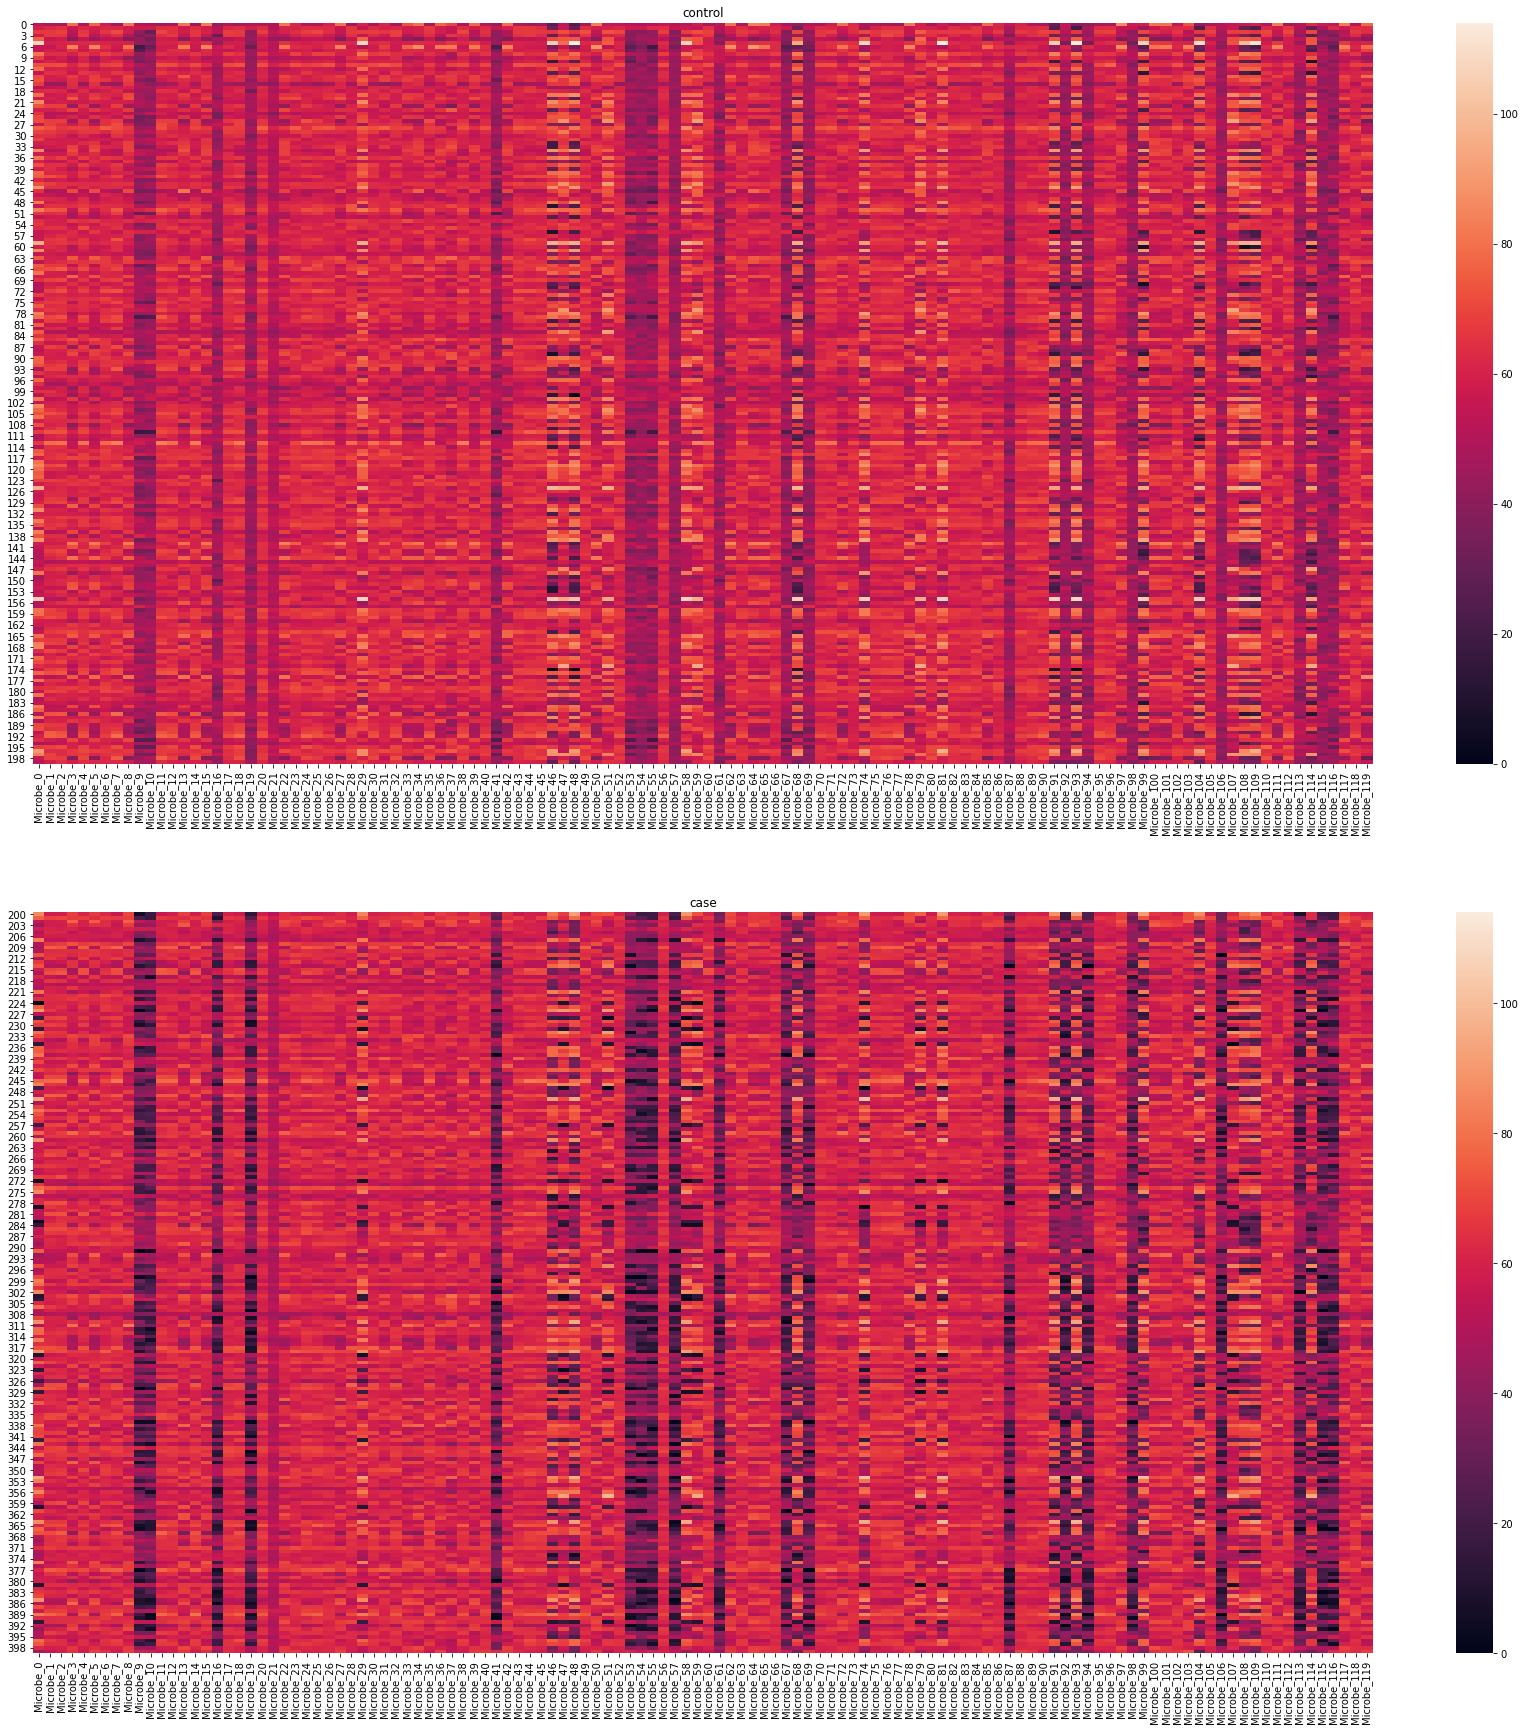

In [88]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(30,30))

min = df_abundance.drop('Group', axis=1).min().min()
max = df_abundance.drop('Group', axis=1).max().max()

heatmap(df_abundance[df_abundance.Group == 'control'].drop('Group', axis=1), ax=ax[0], vmin=min, vmax=max)
heatmap(df_abundance[df_abundance.Group == 'case'].drop('Group', axis=1), ax=ax[1], vmin=min, vmax=max)

ax[0].title.set_text('control')
ax[1].title.set_text('case')


some of the columns are noticably darker in the "case" heatmap than in the "control" heatmap which suggests that "case" subjects are lacking in those microbes compared to "control" subjects.